<a href="https://colab.research.google.com/github/Shabaz18/My-Data-Science-projects/blob/main/deep_learning_projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1NFoWQsP03riYD38NKZ4SdNoQq8nMDoiC')

     |████████████████████████████████| 71kB 5.4MB/s 


In [4]:
!pip install jovian --upgrade --quiet

In [5]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [6]:
project_name = 'cifar100-resnet'

In [7]:
from torchvision.datasets.utils import download_url

# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar100.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
download_url(dataset_url, '.')



Using downloaded and verified file: ./cifar100.tgz


In [8]:
# Looking into the data directory
data_dir = './data/cifar100'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)


['train', 'test']
['reptiles', 'insects', 'flowers', 'large_omnivores_and_herbivores', 'large_man-made_outdoor_things', 'aquatic_mammals', 'vehicles_2', 'household_electrical_devices', 'fruit_and_vegetables', 'small_mammals', 'fish', 'vehicles_1', 'food_containers', 'trees', 'large_natural_outdoor_scenes', 'medium_mammals', 'non-insect_invertebrates', 'large_carnivores', 'household_furniture', 'people']


In [9]:
subclasses_aquatic_mammals = os.listdir(data_dir + "/train/aquatic_mammals")
print(subclasses_aquatic_mammals)
print('total no. of images of dolphins are:', len(data_dir + "/train/aquatic_mammals/dolphin"))

['beaver', 'seal', 'otter', 'whale', 'dolphin']
total no. of images of dolphins are: 45


In [10]:
subclasses_reptiles = os.listdir(data_dir + "/train/reptiles")
print(subclasses_reptiles)
print('total no. of images of snakes are:', len(data_dir + "/train/reptiles/snake"))

['crocodile', 'turtle', 'lizard', 'dinosaur', 'snake']
total no. of images of snakes are: 36


The means and standard deviation for color channels can be found at- https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151

In [11]:
# Data transformation (normalization & data augmentation)
stats = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [12]:
# creating a training dataset
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)



In [30]:
batch_size = 500

In [31]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*3, num_workers=3, pin_memory=True)

In [32]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break



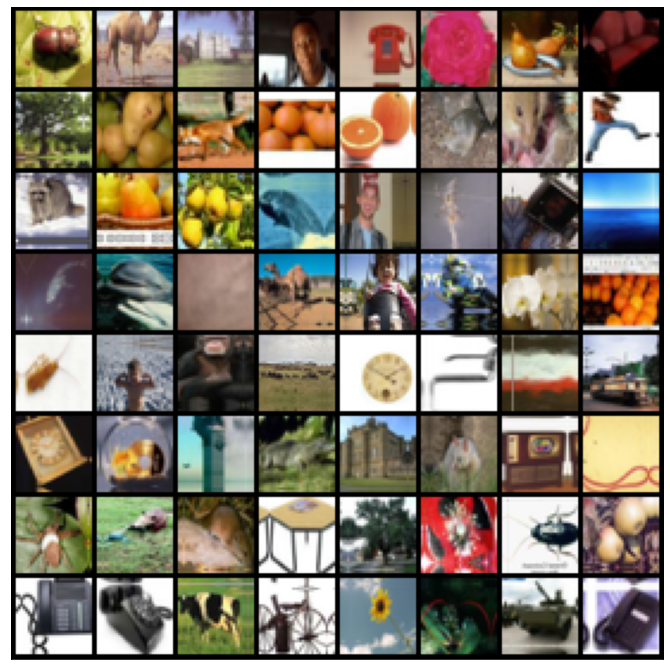

In [33]:
show_batch(train_dl)

In [34]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
device = get_default_device()
device

device(type='cuda')

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [47]:
class ResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()
        self.conv7 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu8 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.conv6(out)
        out = self.relu6(out)
        out = self.conv7(out)
        out = self.relu7(out)
        out = self.conv8(out)
        return self.relu8(out) + x

In [48]:
resnet = to_device(ResidualBlock(), device)

for images, labels in train_dl:
    out = resnet(images)
    print(out.shape)
    break

del resnet, images, labels
torch.cuda.empty_cache()


torch.Size([500, 3, 32, 32])


In [49]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [84]:
def convolution_block(input_channels, output_channels, pool=False):
    layers = [nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(output_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, input_channels, num_classes):
        super().__init__()
        
        self.conv1 = convolution_block(input_channels, 64)
        self.conv2 = convolution_block(64, 128, pool=True)
        self.res1 = nn.Sequential(convolution_block(128, 128), convolution_block(128, 128))
        self.conv3 = convolution_block(128, 256, pool=True)
        self.conv4 = convolution_block(256, 512, pool=True)
        self.res2 = nn.Sequential(convolution_block(512, 512), convolution_block(512, 512))
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [85]:
model = to_device(ResNet9(3, 20), device)

In [86]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [87]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.04180952534079552, 'val_loss': 2.997714042663574}]

In [88]:
epochs = 10
max_lr = 0.015
grad_clip = 0.5
weight_decay = 1e-4
opt_func = torch.optim.Adam


In [89]:
%%time
history += fit(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00416, train_loss: 2.4414, val_loss: 2.0890, val_acc: 0.3467
Epoch [1], last_lr: 0.01138, train_loss: 2.0308, val_loss: 2.2105, val_acc: 0.3530
Epoch [2], last_lr: 0.01500, train_loss: 1.7567, val_loss: 1.8487, val_acc: 0.4382
Epoch [3], last_lr: 0.01426, train_loss: 1.4896, val_loss: 1.4360, val_acc: 0.5383
Epoch [4], last_lr: 0.01218, train_loss: 1.2781, val_loss: 1.7350, val_acc: 0.4852
Epoch [5], last_lr: 0.00917, train_loss: 1.1262, val_loss: 1.3815, val_acc: 0.5685
Epoch [6], last_lr: 0.00583, train_loss: 0.9737, val_loss: 0.9709, val_acc: 0.6842
Epoch [7], last_lr: 0.00282, train_loss: 0.8135, val_loss: 0.8736, val_acc: 0.7189
Epoch [8], last_lr: 0.00074, train_loss: 0.6331, val_loss: 0.7056, val_acc: 0.7762
Epoch [9], last_lr: 0.00000, train_loss: 0.4950, val_loss: 0.6723, val_acc: 0.7874
CPU times: user 54.9 s, sys: 34.1 s, total: 1min 29s
Wall time: 5min 15s


In [90]:
%%time
history += fit(5, 0.0007, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00053, train_loss: 0.4747, val_loss: 0.7252, val_acc: 0.7701
Epoch [1], last_lr: 0.00067, train_loss: 0.4802, val_loss: 0.7224, val_acc: 0.7718
Epoch [2], last_lr: 0.00043, train_loss: 0.4265, val_loss: 0.7131, val_acc: 0.7781
Epoch [3], last_lr: 0.00013, train_loss: 0.3548, val_loss: 0.6685, val_acc: 0.7932
Epoch [4], last_lr: 0.00000, train_loss: 0.3065, val_loss: 0.6684, val_acc: 0.7950
CPU times: user 27.5 s, sys: 17.6 s, total: 45.1 s
Wall time: 2min 37s


In [92]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');



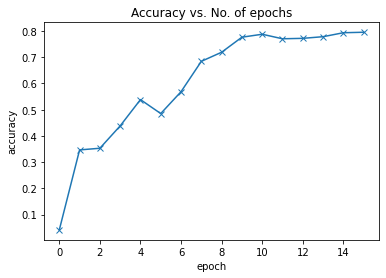

In [93]:
plot_accuracies(history)

In [94]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

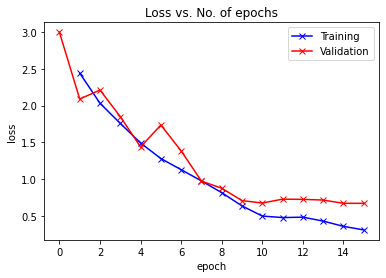

In [95]:
plot_losses(history)

In [96]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

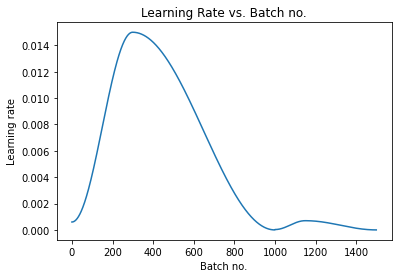

In [97]:
plot_lrs(history)

In [98]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: aquatic_mammals , Predicted: medium_mammals


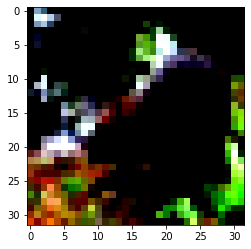

In [99]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: food_containers , Predicted: food_containers


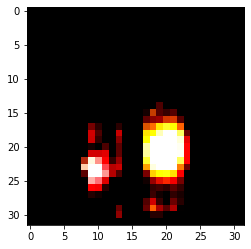

In [102]:
img, label = valid_ds[1500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: vehicles_1 , Predicted: vehicles_1


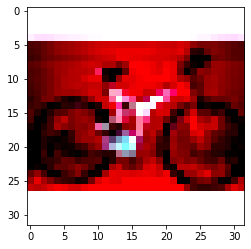

In [103]:
img, label = valid_ds[9000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [104]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

In [105]:
!pip install jovian --upgrade --quiet

In [106]:
import jovian

In [109]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)



[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 


Abort: ignored